In [7]:
from sympy import *
init_printing()

In [8]:
from sympsi import *

In [9]:
from sympsi.boson import *

In [10]:
from sympsi.pauli import *

In [11]:
from sympsi.tests import test_pauli

In [379]:
def coeff(expr, x, right=False):
    
    x_factors, x_operators = x.args_cnc()
    summands = Add.make_args(expr)
    
    coeffs = []
    for summand in summands:
        factors, operators = summand.args_cnc()
        if operators == x_operators:
            coeffs.append(factors)
    return sum(*coeffs)

In [13]:
sz_1 = SigmaZ(1)
sz_2 = SigmaZ(2)
sm_1 = SigmaMinus(1)
sm_2 = SigmaMinus(2)
sp_1 = SigmaPlus(1)
sp_2 = SigmaPlus(2)
sx_2 = SigmaX(2)
sy_2 = SigmaY(2)
a = BosonOp("a")
a_dag = Dagger(a)
ωr, Ω_1, Ω_2, g_1, g_2, g_q, x_1, x_2, Δ_1, Δ_2, t = var("\omega_r, \Omega_1, \Omega_2, g_1, g_2, g_q x_1, x_2, \Delta_1, \Delta_2, t", real=True)

### Тупой способ

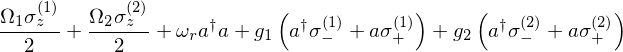

In [14]:
H = ωr*Dagger(a)*a + Ω_1/2*sz_1 + Ω_2/2*sz_2 + g_1*(a_dag*sm_1+a*sp_1) + g_2*(a_dag*sm_2+a*sp_2)
H
# H = ωr*Dagger(a)*a
# H

In [44]:
U1 = exp(x_1*(a_dag*sm_1-a*sp_1))
U2 = exp(x_2*(a_dag*sm_2-a*sp_2))
U0 = exp(x_1*(a_dag*sm_1-a*sp_1)+x_2*(a_dag*sm_2-a*sp_2))

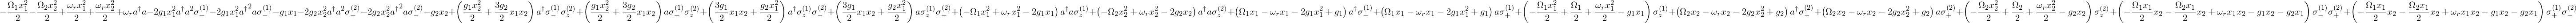

In [19]:
H1 = unitary_transformation(U1, H, allinone=True, expansion_search=False, N=3)
H1 = unitary_transformation(U2, H1, allinone=True, expansion_search=False, N=3)
H1 = unitary_transformation(U, H, allinone=True, expansion_search=False, N=3)
# H1 = drop_c_number_terms(H1.expand())
# qsimplify(H1.expand())
H1

In [20]:
H2 = drop_terms_containing(qsimplify(H1.expand()), [x_1**4, x_2**4, x_1**3*x_2, x_1**2*x_2**2, x_1*x_2**3, x_1**3, x_2**3, x_1*x_2**2, x_1**2*x_2])

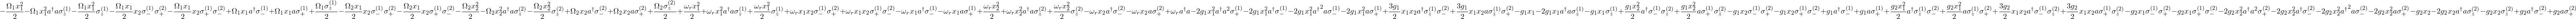

In [21]:
H2

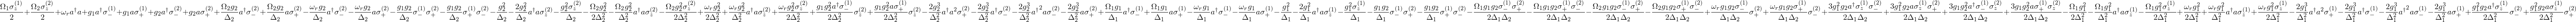

In [22]:
H3 = H2.subs(x_1, g_1/Δ_1).subs(x_2, g_2/Δ_2)

H3

это на первый взгляд не похоже на то, что надо.

### Другой способ

$$
e^{A} B e^{-A} = B + 1/(1!)[A, B] +
                     1/(2!)[A, [A, B]] + 1/(3!)[A, [A, [A, B]]] + ...
                   = B + \sum_n^N 1/(n!)[A, B]^n
$$

$$
U H U^\dagger = H_0 + H_i + [(), H_0] + [(), H_i] + 1/2 [(), [(), H]]+...
$$
$$
U H U^\dagger = H_0 + H_i - H_i + [(), H_i] - 1/2 [(), H_i] + 1/2 [(), [(), H_i]]
$$

$$
U H U^\dagger = H_0 + 1/2 [(), H_i] + 1/2 [(), [(), H_i]]
$$

In [51]:
from sympsi.operatorordering import normal_ordered_form

Проверяем, что $[(), H_0] = -H_i$:

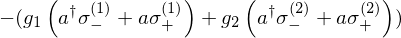

In [98]:
comm = Commutator(U0.exp, ωr*Dagger(a)*a + Ω_1/2*sz_1 + Ω_2/2*sz_2)
for i in range(0, 10):
    comm = comm.expand(commutator=True)
comm = normal_ordered_form(comm.doit())
comm_H0 = simplify(comm.subs(x_1, g_1/(ωr-Ω_1)).subs(x_2, g_2/(ωr - Ω_2))).factor().collect([g_1, g_2])
comm_H0

Работает. Считаем коммутатор с $H_i$:

In [103]:
comm = Commutator(U0.exp, g_1*(a_dag*sm_1+a*sp_1)+g_2*(a_dag*sm_2+a*sp_2))
for i in range(0, 10):
    comm = comm.expand(commutator=True)
comm = normal_ordered_form(comm.doit())
comm_Hi = drop_c_number_terms(qsimplify(comm))
comm_Hi

Считаем полный хамильтонян $H_0+1/2[(), H_i]$

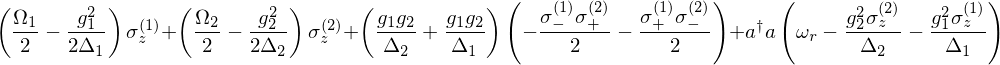

In [121]:
expand(ωr*Dagger(a)*a + Ω_1/2*sz_1 + Ω_2/2*sz_2 + comm_Hi/2)\
                .subs(x_1, g_1/Δ_1).subs(x_2, g_2/Δ_2)\
                .collect(g_1*g_2/Δ_2).collect(g_1*g_2/Δ_1)\
                .collect(-sm_1*sp_2/2-sp_1*sm_2/2)\
                .collect([a_dag*a, sz_1, sz_2])

В чем была проблема? Смотрим на BCH от $H_0$ для N=2 и N=3.

In [390]:
bch_tr = unitary_transformation(U0, ωr*Dagger(a)*a + Ω_1/2*sz_1 + Ω_2/2*sz_2, allinone=True, expansion_search=False, N=2)\
    .subs(x_1, g_1/(ωr-Ω_1)).subs(x_2, g_2/(ωr - Ω_2)).collect([g_1**2, g_2**2])

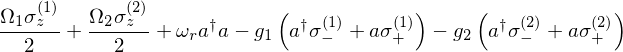

In [394]:
bch_tr_1 = bch_tr.collect([bch_tr.coeff(a_dag*sm_1), bch_tr.coeff(a_dag*sm_2)])\
                .subs(bch_tr.coeff(a_dag*sm_1), bch_tr.coeff(a_dag*sm_1).factor())\
                .subs(bch_tr.coeff(a_dag*sm_2), bch_tr.coeff(a_dag*sm_2).factor())\
                .subs(bch_tr.coeff(sm_1*sp_2), bch_tr.coeff(sm_1*sp_2).factor())\
                .collect(bch_tr.coeff(sm_1*sp_2).factor())\
                .subs(bch_tr.coeff(g_1**2), bch_tr.coeff(g_1**2).factor())\
                .subs(bch_tr.coeff(g_2**2), bch_tr.coeff(g_2**2).factor())\
                .subs(bch_tr.coeff(a_dag*a*sz_1), bch_tr.coeff(a_dag*a*sz_1).factor())\
                .subs(bch_tr.coeff(a_dag*a*sz_2), bch_tr.coeff(a_dag*a*sz_2).factor())
bch_tr_1 = drop_c_number_terms(bch_tr_1.subs(bch_tr_1.coeff(sz_1), bch_tr_1.coeff(sz_1).simplify())\
                .subs(coeff(bch_tr_1, sz_2), coeff(bch_tr_1, sz_2).factor())\
                .subs(coeff(bch_tr_1, sz_1), coeff(bch_tr_1, sz_1).factor()))\
                .collect([sz_1, sz_2])
bch_tr_1

Все прекрасно, как раньше. Теперь N=3:

In [397]:
bch_tr = unitary_transformation(U0, ωr*Dagger(a)*a + Ω_1/2*sz_1 + Ω_2/2*sz_2, allinone=True, expansion_search=False, N=3)\
    .subs(x_1, g_1/(ωr-Ω_1)).subs(x_2, g_2/(ωr - Ω_2)).collect([g_1**2, g_2**2])

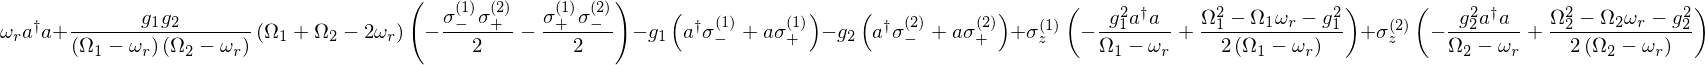

In [398]:
bch_tr_1 = bch_tr.collect([bch_tr.coeff(a_dag*sm_1), bch_tr.coeff(a_dag*sm_2)])\
                .subs(bch_tr.coeff(a_dag*sm_1), bch_tr.coeff(a_dag*sm_1).factor())\
                .subs(bch_tr.coeff(a_dag*sm_2), bch_tr.coeff(a_dag*sm_2).factor())\
                .subs(bch_tr.coeff(sm_1*sp_2), bch_tr.coeff(sm_1*sp_2).factor())\
                .collect(bch_tr.coeff(sm_1*sp_2).factor())\
                .subs(bch_tr.coeff(g_1**2), bch_tr.coeff(g_1**2).factor())\
                .subs(bch_tr.coeff(g_2**2), bch_tr.coeff(g_2**2).factor())\
                .subs(bch_tr.coeff(a_dag*a*sz_1), bch_tr.coeff(a_dag*a*sz_1).factor())\
                .subs(bch_tr.coeff(a_dag*a*sz_2), bch_tr.coeff(a_dag*a*sz_2).factor())
bch_tr_1 = drop_c_number_terms(bch_tr_1.subs(bch_tr_1.coeff(sz_1), bch_tr_1.coeff(sz_1).simplify())\
                .subs(coeff(bch_tr_1, sz_2), coeff(bch_tr_1, sz_2).factor())\
                .subs(coeff(bch_tr_1, sz_1), coeff(bch_tr_1, sz_1).factor()))\
                .collect([sz_1, sz_2])
bch_tr_1

Можно заметить, что из-за разложения до более высокого порядка появляется выражение

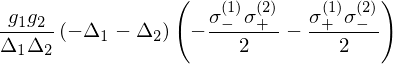

In [473]:
bch_tr_1.args[5].subs(ωr-Ω_1, Δ_1).subs(ωr-Ω_2, Δ_2).subs(Ω_1+Ω_2-2*ωr, -Δ_1-Δ_2)

которое добавляет нам еще связи между кубитами. Как раз он появлялся и раньше, и вообще-то дает ни много ни мало $-g_1 g_2\frac{\Delta_1+\Delta_2}{2\Delta_1\Delta_2}$, а иными словами столько же, сколько полученное ранее из коммутатора H_i, только уже с учтенным знаком минус:

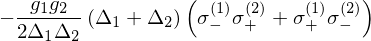

In [476]:
_ = (comm_Hi/2).expand()\
            .collect([sm_1*sp_2, sp_1*sm_2])\
            .collect(-g_1*x_2/2-g_2*x_1/2)\
            .subs({x_1:g_1/Δ_1,x_2:g_2/Δ_2})\
            .args[0]
factor_terms(cancel(factor_terms(_)))

Теперь проводим BCH с H_i

In [479]:
bch_tr = unitary_transformation(U0, g_1*(a_dag*sm_1+a*sp_1)+g_2*(a_dag*sm_2+a*sp_2), allinone=True, expansion_search=False, N=3)\
    .subs(x_1, g_1/(ωr-Ω_1)).subs(x_2, g_2/(ωr - Ω_2)).collect([g_1**2, g_2**2])

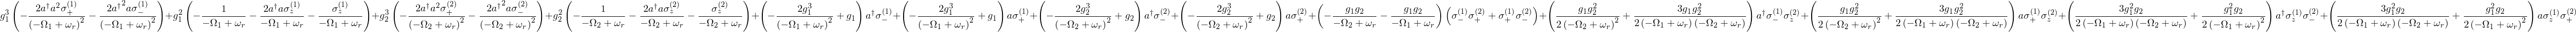

In [480]:
(bch_tr.collect(bch_tr.coeff(sm_1*sp_2)))

Выбросим совсем уж маленькие первые четыре скобки:

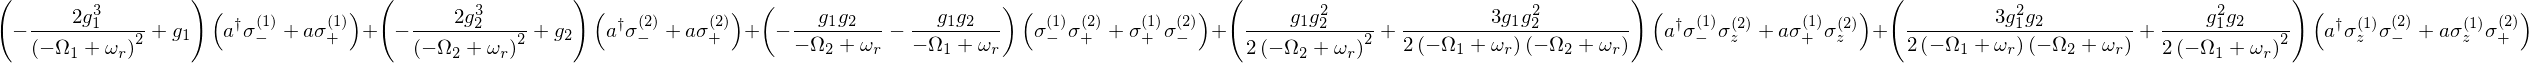

In [456]:
h_i_bch = drop_terms_containing(_, [g_1**3, g_2**3, g_1**2, g_2**2])
h_i_bch

Складываем с BCH от $H_0$:

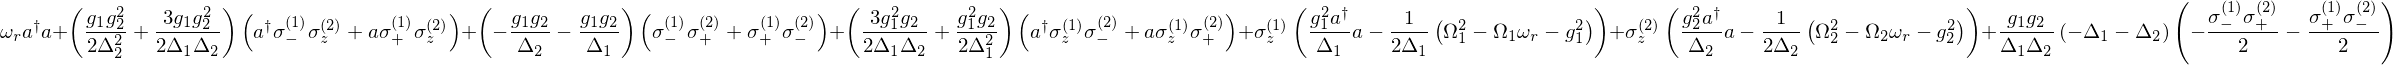

In [520]:
full = (bch_tr_1+h_i_bch)\
        .collect([a_dag*sm_1+a*sp_1, a_dag*sm_2+a*sp_2])\
        .collect(-sm_1*sp_2/2-sp_1*sm_2/2)\
        .subs(ωr-Ω_1, Δ_1).subs(ωr-Ω_2, Δ_2).subs(Ω_1+Ω_2-2*ωr, -Δ_1-Δ_2)
full = drop_terms_containing(full, [g_1**3, g_2**3])
full

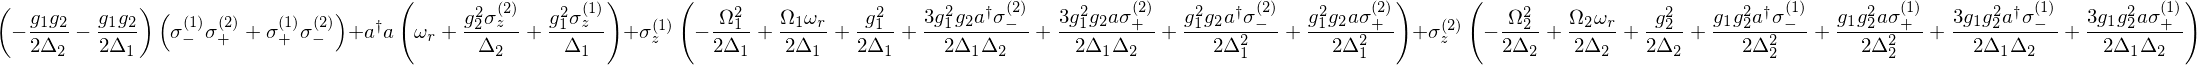

In [528]:
full1 = qsimplify(full.expand()).collect(sm_1*sp_2).collect(sm_2*sp_1)
full2 = full1.collect(coeff(full1, sm_1*sp_2)).collect(a_dag*a).collect([sz_1, sz_2])
full2


Ну в общем кажись и так все получилось. Не буду маленькие дальше выкидывать.